In [1]:
import itertools
from collections import defaultdict
from pathlib import Path

import os
import json
import torch
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ase.neighborlist import natural_cutoffs, NeighborList
from ase.io import read, Trajectory

# optional. nglview for visualization
# import nglview as nv

In [2]:
"""
functions for loading simulated trajectories and computing observables.
"""

def get_thermo(filename):
    """
    read thermo logs.
    """
    with open(filename, 'r') as f:
        thermo = f.read().splitlines()
        sim_time, Et, Ep, Ek, T = [], [], [], [], []
        for i in range(1, len(thermo)):
            try:
                t, Etot, Epot, Ekin, Temp = [float(x) for x in thermo[i].split(' ') if x]
                sim_time.append(t)
                Et.append(Etot)
                Ep.append(Epot)
                Ek.append(Ekin)
                T.append(Temp)
            except:
                sim_time, Et, Ep, Ek, T = [], [], [], [], []
    thermo = {
        'time': sim_time,
        'Et': Et,
        'Ep': Ep,
        'Ek': Ek,
        'T': T
    }
    return thermo

def get_test_metrics(md_dir):
    """
    read test metrics such as force error.
    """
    run_metrics = {}
    with open(md_dir / 'test_metric.json', 'r') as f:
        test_metric = json.load(f)
        
        if 'mae_f' in test_metric:
            fmae = test_metric['mae_f']
            run_metrics['fmae'] = fmae
        elif 'f_mae' in test_metric:
            fmae = test_metric['f_mae']
            run_metrics['fmae'] = fmae
        elif 'forces_mae' in test_metric:
            fmae = test_metric['forces_mae']['metric']
            run_metrics['fmae'] = fmae
            
        if 'mae_e' in test_metric:
            emae = test_metric['mae_e']
            run_metrics['emae'] = emae
        elif 'e_mae' in test_metric:
            emae = test_metric['e_mae']
            run_metrics['emae'] = emae
        elif 'energy_mae' in test_metric:
            emae = test_metric['energy_mae']['metric']
            run_metrics['emae'] = emae
            
        if 'num_params' in test_metric:
            run_metrics['n_params'] = test_metric['num_params']
        if 'running_time' in test_metric:
            run_metrics['running_time'] = test_metric['running_time']
    return run_metrics

def mae(x, y, factor):
    return np.abs(x-y).mean() * factor

def distance_pbc(x0, x1, lattices):
    delta = torch.abs(x0 - x1)
    lattices = lattices.view(-1,1,3)
    delta = torch.where(delta > 0.5 * lattices, delta - lattices, delta)
    return torch.sqrt((delta ** 2).sum(dim=-1))

def get_diffusivity_traj(pos_seq, dilation=1):
    """
    Input: B x N x T x 3
    Output: B x T
    """
    # substract CoM
    bsize, time_steps = pos_seq.shape[0], pos_seq.shape[2]
    pos_seq = pos_seq - pos_seq.mean(1, keepdims=True)
    msd = (pos_seq[:, :, 1:] - pos_seq[:, :, 0].unsqueeze(2)).pow(2).sum(dim=-1).mean(dim=1)
    diff = msd / (torch.arange(1, time_steps)*dilation) / 6
    return diff.view(bsize, time_steps-1)

def get_smoothed_diff(xyz):
    seq_len = xyz.shape[0] - 1
    diff = torch.zeros(seq_len)
    for i in range(seq_len):
        diff[:seq_len-i] += get_diffusivity_traj(xyz[i:].transpose(0, 1).unsqueeze(0)).flatten()
    diff = diff / torch.flip(torch.arange(seq_len),dims=[0])
    return diff

## MD17

In [3]:
def get_hr(traj, bins):
    """
    compute h(r) for MD17 simulations.
    traj: T x N_atoms x 3
    """
    pdist = torch.cdist(traj, traj).flatten()
    hist, _ = np.histogram(pdist[:].flatten().numpy(), bins, density=True)
    return hist

In [4]:
def load_run(md_dir, xlim, bins, stability_threshold, gt_traj, hist_gt):
    """
    md_dir: directory to the finished MD simulation.
    """
    if not isinstance(md_dir, Path):
        md_dir = Path(md_dir)
    
    model_name = md_dir.parts[-2]
    seed = md_dir.parts[-1][-1]
    run = {'name': (model_name + f'_seed_{seed}'),}
    
    # get bonds
    traj = Trajectory(md_dir / 'atoms.traj')
    atoms = traj[0]
    NL = NeighborList(natural_cutoffs(atoms), self_interaction=False)
    NL.update(atoms)
    bonds = NL.get_connectivity_matrix().todense().nonzero()
    bonds = torch.tensor(bonds)
    
    # process trajectory
    traj = [x.positions for x in traj]
    run['traj'] = torch.from_numpy(np.stack(traj))
    run['traj'] = torch.unique(run['traj'], dim=0) # remove repeated frames from restarting.

    # load thermo log
    run['thermo'] = get_thermo(md_dir / 'thermo.log')
    T = np.array(run['thermo']['T']) 
    collapse_pt = len(T)
    md_time = np.array(run['thermo']['time'])
    
    # track stability
    bond_lens = distance_pbc(
        gt_traj[:, bonds[0]], gt_traj[:, bonds[1]], torch.FloatTensor([30., 30., 30.]))
    mean_bond_lens = bond_lens.mean(dim=0)
    
    for i in range(1, len(T)):
        bond_lens = distance_pbc(
            run['traj'][(i-1):i, bonds[0]], run['traj'][(i-1):i, bonds[1]], torch.FloatTensor([30., 30., 30.]))
        max_dev = (bond_lens[0] - mean_bond_lens).abs().max()
        if  max_dev > stability_threshold:
            collapse_pt = i
            break
    run['collapse_pt'] = collapse_pt
    
    # compute h(r)
    hist_pred = get_hr(run['traj'][0:collapse_pt], bins)
    hr_mae = mae(hist_pred, hist_gt, xlim)
    run['hr'] = hist_pred
    run['hr_error'] = hr_mae
    
    # load test metrics
    if (md_dir / 'test_metric.json').exists():
        test_metrics = get_test_metrics(md_dir)
        run.update(test_metrics)
    
    return run

force mae: 8.0 meV/A 
stability: 25.0 ps 
h(r) mae: 0.06


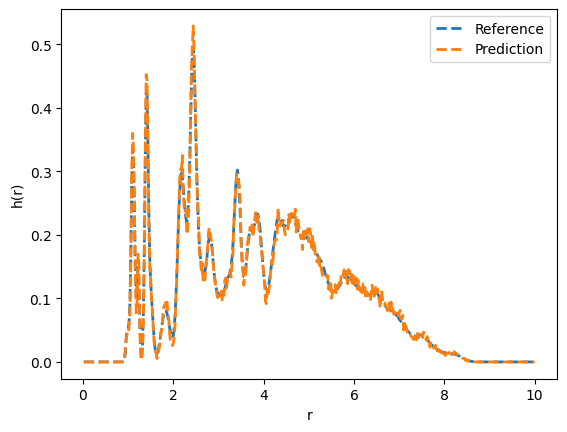

In [6]:
# eval parameters
stability_threshold = 0.5
xlim = 10
n_bins = 500
bins = np.linspace(1e-6, xlim, n_bins + 1) # for computing h(r)

# select molecule and get ground truth data
molecule = 'aspirin'
DATAPATH = f'{molecule}_dft.npz'
gt_data = np.load(DATAPATH)
gt_traj = torch.FloatTensor(gt_data.f.R)
hist_gt = get_hr(gt_traj, bins)


# load run and plot h(r)
# md_dir = Path('./example_sim/aspirin_dimenet')
md_dir = Path('MODELPATH/md17-aspirin_10k_gemnet_t_dT/md_25ps_123')
run = load_run(md_dir, xlim, bins, stability_threshold, gt_traj, hist_gt)
plt.plot(bins[1:], hist_gt, label='Reference', linewidth=2, linestyle='--')
plt.plot(bins[1:], run['hr'], label='Prediction', linewidth=2, linestyle='--')
plt.xlabel('r')
plt.ylabel('h(r)')
plt.legend()

# metrics
force_mae = run['fmae'] * 1000
collapse_ps = (run['collapse_pt']-1) / 20
hr_mae = run['hr_error']
print(f'force mae: {force_mae:.1f} meV/A \nstability: {collapse_ps:.1f} ps \nh(r) mae: {hr_mae:.2f}')

In [15]:
# visualization
nv.show_asetraj(Trajectory(md_dir / 'atoms.traj'))

NGLWidget(max_frame=753)

## Water

In [ ]:
xlim = 6
nbins = 1000
bins = np.linspace(1e-6, xlim, nbins+1)
stability_threshold = 3.0
diffusivity_cutoff = 3000

In [ ]:
def distance_pbc_select(x, lattices, indices0, indices1):
    x0 = x[:, indices0]
    x1 = x[:, indices1]
    x0_size = x0.shape[1]
    x1_size = x1.shape[1]
    x0 = x0.repeat([1, x1_size, 1])
    x1 = x1.repeat_interleave(x0_size, dim=1)
    delta = torch.abs(x0 - x1)
    delta = torch.where(delta > 0.5 * lattices, delta - lattices, delta)
    return torch.sqrt((delta ** 2).sum(axis=-1))

def get_water_rdfs(data_seq, ptypes, lattices, bins, device='cpu'):
    """
    get atom-type conditioned water RDF curves.
    """
    data_seq = data_seq.to(device).float()
    lattices = lattices.to(device).float()
    
    type2indices = {
        'H': ptypes == 1,
        'O': ptypes == 8
    }
    pairs = [('O', 'O'), ('H', 'H'), ('H', 'O')]
    
    data_seq = ((data_seq / lattices) % 1) * lattices
    all_rdfs = {}
    n_rdfs = 3
    for idx in range(n_rdfs):
        type1, type2 = pairs[idx]    
        indices0 = type2indices[type1].to(device)
        indices1 = type2indices[type2].to(device)
        data_pdist = distance_pbc_select(data_seq, lattices, indices0, indices1)
        
        data_pdist = data_pdist.flatten().cpu().numpy()
        data_shape = data_pdist.shape[0]
            
        data_pdist = data_pdist[data_pdist != 0]
        data_hist, _ = np.histogram(data_pdist, bins)
        rho_data = data_shape / torch.prod(lattices).cpu().numpy() 
        Z_data = rho_data * 4 / 3 * np.pi * (bins[1:] ** 3 - bins[:-1] ** 3)
        data_rdf = data_hist / Z_data
        all_rdfs[type1 + type2] = data_rdf
        
    return all_rdfs

def load_run(md_dir, atom_types, xlim, bins, stability_threshold, gt_rdfs, gt_diff):
    if not isinstance(md_dir, Path):
        md_dir = Path(md_dir)
        
    model_name = md_dir.parts[-2]
    seed = md_dir.parts[-1][-1]
    run = {'name': (model_name + f'_seed_{seed}'),}
    
    # process trajectory
    traj = [x.positions for x in Trajectory(md_dir / 'atoms.traj')]
    run['traj'] = torch.from_numpy(np.stack(traj))
    run['traj'] = torch.unique(run['traj'], dim=0) # remove repeated frames from restarting.
    
    # load thermo log
    run['thermo'] = get_thermo(md_dir / 'thermo.log')
    md_time = np.array(run['thermo']['time'])
    T = np.array(run['thermo']['T']) 
    collapse_pt = len(T)
    for i in (range(1, len(T)-rdf_check_interval)):
        timerange = torch.arange(i, i + rdf_check_interval)
        current_rdf = get_water_rdfs(run['traj'][timerange], atom_types, lattices, bins)
        rdf_mae_oo = mae(current_rdf['OO'], gt_rdfs['OO'], xlim)
        rdf_mae_ho = mae(current_rdf['HO'], gt_rdfs['HO'], xlim)
        rdf_mae_hh = mae(current_rdf['HH'], gt_rdfs['HH'], xlim)
        if max([rdf_mae_oo, rdf_mae_ho, rdf_mae_hh]) > stability_threshold:
            collapse_pt = i
            break

    run['collapse_pt'] = collapse_pt        

    # at least 100 ps for computing diffusivity.
    if collapse_pt >= 1000:
        run['diffusivity'] = get_smoothed_diff(
            run['traj'][:collapse_pt:10, atom_types == 8])[:100]
        run['diff_error'] = float((run['diffusivity'][-1] - gt_diff[-1]).abs())
        run['end_diff'] = float(run['diffusivity'][-1])
    else:
        run['diffusivity'] = None
        run['diff_error'] = np.inf
        run['end_diff'] = np.inf
        
    # at least 1 ps for computing RDFs.
    if collapse_pt >= 10:
        run['rdf'] = get_water_rdfs(run['traj'][:collapse_pt], atom_types, lattices, bins)
        run['rdf_error'] = [mae(run['rdf'][k], gt_rdfs[k], xlim) for k in ['OO', 'HH', 'HO']]
    else:
        run['rdf'] = None
        run['rdf_error'] = [np.inf] * 3
        
    # load test metrics
    if (md_dir / 'test_metric.json').exists():
        test_metrics = get_test_metrics(md_dir)
        run.update(test_metrics)
        
    return run


In [ ]:
# eval parameters
stability_threshold = 3.0
rdf_check_interval = 10 # 1 ps
xlim = 6
n_bins = 500
bins = np.linspace(1e-6, xlim, n_bins + 1) # for computing RDF

# get ground truth data
DATAPATH = 'DATAPATH/mdbench_data/flexwater/flexwater.npy'
gt_data = np.load(DATAPATH, allow_pickle=True).item()
atom_types = torch.tensor(gt_data['atom_types'])
lattices = torch.tensor(gt_data['lengths'][0]).float()
gt_traj = torch.tensor(gt_data['unwrapped_coords'])
gt_diff = get_smoothed_diff(gt_traj[0::100, atom_types==8])[:100] # track diffusivity of oxygen atoms, unit is A^2/ps
gt_rdfs = get_water_rdfs(gt_traj[::10], atom_types, lattices, bins) # match the recording frequency of 0.1 ps

# load run and plot RDFs
md_dir = Path('./example_sim/water-1k_schnet')
run = load_run(md_dir, atom_types, xlim, bins, stability_threshold, gt_rdfs, gt_diff)

plt.subplots_adjust()
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.rc('legend', fontsize=24)
plt.rc('figure', titlesize=24)
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=24)
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(18, 4)
fig.tight_layout(h_pad=3, w_pad=1)

for i, elem in enumerate(['OO', 'HH', 'HO']):
    axs[i].plot(bins[:-1], gt_rdfs[elem], label='Reference', linewidth=3, linestyle='--')
    axs[i].plot(bins[:-1], run['rdf'][elem], label='Prediction', linewidth=3, linestyle='--')
    axs[i].set(title=f'RDF {elem}', xlabel='r')
    axs[i].legend()
axs[0].set_ylabel('RDF(r)')

# metrics
force_mae = run['fmae'] * 1000
collapse_ps = (run['collapse_pt']-1) / 10
rdf_oo_mae = run['rdf_error'][0]
rdf_hh_mae = run['rdf_error'][1]
rdf_ho_mae = run['rdf_error'][2]
diff_mae = run['diff_error'] * 10 # A^2/ps -> 10^-9 m^2/s 
print(f'force mae: {force_mae:.1f} meV/A \nstability: {collapse_ps:.1f} ps \nRDF (O,O) mae: {rdf_oo_mae:.2f}' + 
     f'\nRDF (H,H) mae: {rdf_hh_mae:.2f} \nRDF (H,O) mae: {rdf_ho_mae:.2f} \nDiffusivity mae: {diff_mae:.2f} x 10^-9 m^2/s ')

In [ ]:
# visualization (PBC is not incorporated)
nv.show_asetraj(Trajectory(md_dir / 'atoms.traj'))

## Alanine dipeptide

In [ ]:
kBT=2.49 # constant at 300 K

def os_obtain_fes(md_dir):
    """
    run a plumed command to get the FES from simulation outputs.
    """
    cmd = os.getcwd()
    os.chdir(f'{str(md_dir)}')
    os.system('plumed sum_hills --hills HILLS --mintozero --bin 60,60')
    os.chdir(cmd)

def load_fes(filename):
    """
    load FES generated from plumed.
    """
    X = np.loadtxt(filename, skiprows=9)
    xg = X[:,0].reshape((60, 60))
    yg = X[:,1].reshape((60, 60))
    energies = zg = X[:,2].reshape((60, 60))
    return xg, yg, zg

def plot_fes(xg, yg, zg):
    energies = zg
    v = np.arange(-9, +0.5, 0.5) # Contours to plot.
    fig = plt.figure(figsize=(10, 8.2))
    energies = (energies - np.min(energies))
    cmap=plt.cm.magma
    cmap.set_bad(color='white')
    img = plt.imshow(energies/kBT, interpolation='nearest', cmap = cmap)
    plt.gca().invert_yaxis()
    cb = plt.colorbar()
    cb.set_label("G [kBT]")
    plt.xlabel("$\phi$")
    plt.ylabel("$\psi$")
    plt.xlim((-np.pi, np.pi))
    plt.ylim((-np.pi, np.pi))
    plt.axis("equal")
    cb.ax.set_title(r'$\tilde{F}/k_BT$')
    return xg, yg, zg

def get_pmf(zg):
    pmf = np.exp(-zg/kBT)
    pmf = pmf/ pmf.sum()
    X = pmf.sum(axis=0)
    Y = pmf.sum(axis=1)
    pmf_x = -kBT * np.log(X)
    pmf_y = -kBT * np.log(Y)
    pmf_x -= pmf_x.min()
    pmf_y -= pmf_y.min()
    return pmf_x, pmf_y

def load_run(md_dir, gt_traj, stability_threshold):
    if not isinstance(md_dir, Path):
        md_dir = Path(md_dir)
        
    model_name = md_dir.parts[-2]
    seed = md_dir.parts[-1][-1]
    run = {'name': (model_name + f'_seed_{seed}'),}
    
    # get bonds
    traj = Trajectory(md_dir / 'atoms.traj')
    atoms = traj[0]
    lattices = torch.from_numpy(atoms.cell.diagonal()).float()
    NL = NeighborList(natural_cutoffs(atoms), self_interaction=False)
    NL.update(atoms)
    bonds = NL.get_connectivity_matrix().todense().nonzero()
    bonds = torch.tensor(bonds)
    
    # process trajectory
    traj = [x.positions for x in traj]
    run['traj'] = torch.from_numpy(np.stack(traj))
    run['traj'] = torch.unique(run['traj'], dim=0) # remove repeated frames from restarting.

    # track stability
    bond_lens = distance_pbc(gt_traj[:, bonds[0]], gt_traj[:, bonds[1]], lattices)
    mean_bond_lens = bond_lens.mean(dim=0)
    run['thermo'] = get_thermo(md_dir / 'thermo.log')
    T = np.array(run['thermo']['T']) 
    collapse_pt = len(T)
    md_time = np.array(run['thermo']['time'])
    for i in range(1, len(T)):
        bond_lens = distance_pbc(
            run['traj'][(i-1):i, bonds[0]], run['traj'][(i-1):i, bonds[1]], lattices)
        max_dev = (bond_lens[0] - mean_bond_lens).abs().max()
        if  max_dev > stability_threshold:
            collapse_pt = i
            break

    run['collapse_pt'] = collapse_pt
    if (md_dir / 'fes.dat').exists():
        _, _, zg = load_fes(md_dir / 'fes.dat')
        run['fes'] = zg
    else:
        run['fes'] = None

    # load test metrics
    if (md_dir / 'test_metric.json').exists():
        test_metrics = get_test_metrics(md_dir)
        run.update(test_metrics)
    
    return run

In [ ]:
stability_threshold = 0.5

DATAPATH = 'DATAPATH/mdbench_data/ala_src/ala.npy'
gt_data = np.load(DATAPATH, allow_pickle=True).item()
gt_traj = torch.from_numpy(gt_data['pos'])
_, _, gt_fes = load_fes('./alanine_dipeptide_files/fes.dat')
pmf_phi, pmf_psi = get_pmf(gt_fes)

md_dir = Path('./example_sim/ala_nequip')
os_obtain_fes(md_dir)
run = load_run(md_dir, gt_traj, stability_threshold)
pmf_phi_pred, pmf_psi_pred = get_pmf(run['fes'])

In [ ]:
# metrics
force_mae = run['fmae'] * 1000
phi_mae = mae(pmf_phi, pmf_phi_pred, 6.28)
psi_mae = mae(pmf_psi, pmf_psi_pred, 6.28)
print(f'force mae: {force_mae:.1f} meV/A \nphi mae: {phi_mae:.1f} \npsi mae: {psi_mae:.1f}')

In [ ]:
# plot PMF (one-dim FES)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22) 
plt.rc('legend', fontsize=22)
plt.rc('figure', titlesize=30)
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=24)

x_axis = np.linspace(-180, 180, 60)

plt.subplots_adjust()
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(11, 4.5)
fig.tight_layout(pad=0)

ax = axs[0]
ax.plot(x_axis, pmf_phi, label='Reference', linewidth=4)
ax.set(xlabel=r'$\phi$ [degree]', ylabel='F [kJ/mol]', xticks=[-180, -90, 0, 90, 180])
ax.plot(x_axis, pmf_phi_pred, label='Prediction',linewidth=4)
lines, labels = ax.get_legend_handles_labels()
ax.legend()

ax = axs[1]
ax.plot(x_axis, pmf_psi, label='Reference',linewidth=4)
ax.set(xlabel=r'$\psi$ [degree]', ylabel='', xticks=[-180, -90, 0, 90, 180])
ax.plot(x_axis, pmf_psi_pred, label='Prediction',linewidth=4)
lines, labels = ax.get_legend_handles_labels()
ax.legend()

In [ ]:
# plot FES
plt.subplots_adjust()
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12.5, 6)
fig.tight_layout(pad=0)

ax = axs[0]
energies = gt_fes
energies = (energies - np.min(energies))
img = ax.imshow(energies, interpolation='nearest', cmap = plt.cm.magma)
ax.invert_yaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(img, cax=cax, orientation='vertical')

ax.set(xlabel="$\phi$ [degree]", ylabel="$\psi$ [degree]", title='Reference')
ax.axis("equal")
ax.set(xticks=[0,15,30,45,59], xticklabels=[-180, -90, 0, 90, 180],
       yticks=[0,15,30,45,59], yticklabels=[-180, -90, 0, 90, 180])
cb.ax.set_title('F [kJ/mol]')


ax = axs[1]
energies = run['fes']
energies = (energies - np.min(energies))
img = ax.imshow(energies, interpolation='nearest', cmap = plt.cm.magma)
ax.invert_yaxis()
divider = make_axes_locatable(ax)
ax.set(xticks=[0,15,30,45,59], xticklabels=[-180, -90, 0, 90, 180],
       yticks=[],yticklabels=[])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(img, cax=cax, orientation='vertical')

ax.set(xlabel="$\phi$ [degree]", title='Prediction')
ax.axis("equal")
cb.ax.set_title('F [kJ/mol]')

In [ ]:
# adjust positions to show under pbc properly
traj = Trajectory(md_dir / 'atoms.traj')
lattices = (traj[0].cell.diagonal())[0]
new_traj = []
for i in range(len(traj)):
    atoms = traj[i]
    atoms.positions = (atoms.positions + np.array([0,0,10])) % lattices
    new_traj.append(atoms)

# visualization
nv.show_asetraj(new_traj)

## LiPS

In [ ]:
def compute_image_flag(cell, fcoord1, fcoord2):
    supercells = torch.FloatTensor(list(itertools.product((-1, 0, 1), repeat=3))).to(cell.device)
    fcoords = fcoord2[:, None] + supercells
    coords = fcoords @ cell
    coord1 = fcoord1 @ cell
    dists = torch.cdist(coord1[:, None], coords).squeeze()
    image = dists.argmin(dim=-1)
    return supercells[image].long()

def frac2cart(fcoord, cell):
    return fcoord @ cell

def cart2frac(coord, cell):
    invcell = torch.linalg.inv(cell)
    return coord @ invcell

# the source data is in wrapped coordinates. need to unwrap it for computing diffusivity.
def unwrap(pos0, pos1, cell):
    fcoords1 = cart2frac(pos0, cell)
    fcoords2 = cart2frac(pos1, cell)
    flags = compute_image_flag(cell, fcoords1, fcoords2)
    remapped_frac_coords = cart2frac(pos1, cell) + flags
    return frac2cart(remapped_frac_coords, cell)

# different from previous functions, now needs to deal with non-cubic cells. 
def compute_distance_matrix_batch(cell, cart_coords, num_cells=1):
    pos = torch.arange(-num_cells, num_cells+1, 1).to(cell.device)
    combos = torch.stack(
        torch.meshgrid(pos, pos, pos, indexing='xy')
            ).permute(3, 2, 1, 0).reshape(-1, 3).to(cell.device)
    shifts = torch.sum(cell.unsqueeze(0) * combos.unsqueeze(-1), dim=1)
    # NxNxCells distance array
    shifted = cart_coords.unsqueeze(2) + shifts.unsqueeze(0).unsqueeze(0)
    dist = cart_coords.unsqueeze(2).unsqueeze(2) - shifted.unsqueeze(1)
    dist = dist.pow(2).sum(dim=-1).sqrt()
    # But we want only min
    distance_matrix = dist.min(dim=-1)[0]
    return distance_matrix

def get_lips_rdf(data_seq, lattices, bins, device='cpu'):
    data_seq = data_seq.to(device).float()
    lattices = lattices.to(device).float()
    
    lattice_np = lattices.cpu().numpy()
    volume = float(abs(np.dot(np.cross(lattice_np[0], lattice_np[1]), lattice_np[2])))
    data_pdist = compute_distance_matrix_batch(lattices, data_seq)

    data_pdist = data_pdist.flatten().cpu().numpy()
    data_shape = data_pdist.shape[0]

    data_pdist = data_pdist[data_pdist != 0]
    data_hist, _ = np.histogram(data_pdist, bins)

    rho_data = data_shape / volume
    Z_data = rho_data * 4 / 3 * np.pi * (bins[1:] ** 3 - bins[:-1] ** 3)
    rdf = data_hist / Z_data
        
    return rdf

def load_run(md_dir, atomic_numbers, cell, xlim, bins, stability_threshold, gt_rdf, gt_diff):
    if not isinstance(md_dir, Path):
        md_dir = Path(md_dir)
        
    model_name = md_dir.parts[-2]
    seed = md_dir.parts[-1][-1]
    run = {'name': (model_name + f'_seed_{seed}')}

    run['traj'] = Trajectory(md_dir / 'atoms.traj')
    run['traj'] = torch.from_numpy(np.stack([run['traj'][i].positions 
                                                  for i in range(len(run['traj']))]))
    run['thermo'] = get_thermo( md_dir / 'thermo.log')

    md_time = np.array(run['thermo']['time'])
    T = np.array(run['thermo']['T']) 
    collapse_pt = len(T)
    for i in (range(1, len(T)-rdf_check_interval)):
        timerange = torch.arange(i, i + rdf_check_interval)
        current_rdf = get_lips_rdf(run['traj'][timerange], cell, bins)
        rdf_mae = mae(current_rdf, gt_rdf, xlim)
        if rdf_mae > stability_threshold:
            collapse_pt = i
            break

    run['collapse_pt'] = collapse_pt 

    run['rdf'] = get_lips_rdf(run['traj'][:collapse_pt], cell, bins)
    run['rdf_error'] = mae(run['rdf'], gt_rdf, xlim)

    if collapse_pt > 3200:
        # removing the first 5 ps for equilibrium. use the diffusivity at 40 ps as a convergence value.
        # some random error is unavoidable with 50-ps reference simulations.
        diff = get_smoothed_diff(run['traj'][400:collapse_pt:4, atomic_numbers == 3])
        run['diffusivity'] = diff[700] * 20 * 1e-8
        run['end_diff'] = float(run['diffusivity'])
        run['diff_error'] = np.abs(float(run['diffusivity']) - float(gt_diff[700]))
    else:
        run['diffusivity'] = None
        run['end_diff'] = np.inf
        run['diff_error'] = np.inf

    # load test metrics
    if (md_dir / 'test_metric.json').exists():
        test_metrics = get_test_metrics(md_dir)
        run.update(test_metrics)

    return run

In [ ]:
stability_threshold = 1.0
rdf_check_interval = 80 # 1 ps. recording freq is 0.0125 ps. 

xlim = 6
nbins = 500
bins = np.linspace(1e-6, xlim, nbins + 1)

atoms = read('DATAPATH/lips/lips.xyz', index=':', format='extxyz')
n_points = len(atoms)
positions, cell, atomic_numbers = [], [], []
for i in range(n_points):
    positions.append(atoms[i].get_positions())
    cell.append(atoms[i].get_cell())
    atomic_numbers.append(atoms[i].get_atomic_numbers())
positions = torch.from_numpy(np.array(positions))
cell = torch.from_numpy(np.array(cell)[0])
atomic_numbers = torch.from_numpy(np.array(atomic_numbers)[0])

# unwrap positions
all_displacements = []
for i in (range(1, len(positions))):
    next_pos = unwrap(positions[i-1], positions[i], cell)
    displacements = next_pos - positions[i-1]
    all_displacements.append(displacements)
displacements = torch.stack(all_displacements)
accum_displacements = torch.cumsum(displacements, dim=0)
positions = torch.cat([positions[0].unsqueeze(0), positions[0] + accum_displacements], dim=0)


gt_rdf = get_lips_rdf(positions[::], cell, bins, device='cpu')
# Li diffusivity unit in m^2/s. remove the first 5 ps as equilibrium.
# Desirably, we want longer trajectories for computing diffusivity.
gt_diff = get_smoothed_diff((positions[2500:None:25, atomic_numbers == 3])) * 20 * 1e-8

# load run and plot RDFs
md_dir = Path('./example_sim/lips_gemnet-t')
run = load_run(md_dir, atomic_numbers, cell, xlim, bins, stability_threshold, gt_rdf, gt_diff)

xaxis = np.linspace(1e-6, xlim, nbins)
plt.plot(xaxis, gt_rdf, label='Reference', linewidth=2, linestyle='--')
plt.plot(xaxis, run['rdf'], label='Prediction', linewidth=2, linestyle='--')
plt.legend()

force_mae = run['fmae'] * 1000
collapse_ps = (run['collapse_pt']-1) / 80
rdf_mae = run['rdf_error']
diff_mae = run['diff_error'] * 1e9
print(f'force mae: {force_mae:.1f} meV/A \nstability: {collapse_ps:.1f} ps \nRDF mae: {rdf_mae:.2f}' +
      f'\nDiffusivity mae: {diff_mae:.2f} x 10^-9 m^2/s')

In [ ]:
# visualization
traj = Trajectory(md_dir / 'atoms.traj')
nv.show_asetraj(traj)